In [34]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable


from ipywidgets import interact, fixed
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib.patches import Ellipse
from scipy import linalg

#import plotly.express as px
import urllib.request
import zipfile
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
from sklearn.decomposition import PCA, FactorAnalysis
from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity
from sklearn.preprocessing import StandardScaler
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from sklearn.model_selection import GridSearchCV
import textwrap



import os
# os.environ["OMP_NUM_THREADS"] = "2"

from sklearn.mixture import GaussianMixture



from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_percentage_error, mean_squared_error,r2_score,mean_absolute_error,make_scorer

import shap
import ast

from pathlib import Path  


from sklearn.cluster import KMeans
import geopandas as gpd

import matplotlib.patches as mpatches
from matplotlib.lines import Line2D


from adjustText import adjust_text
from matplotlib.patches import Patch


from matplotlib.ticker import FuncFormatter

from sklearn.metrics import r2_score

from faker import Faker


import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")



<h1 style="font-size: 32px;">XGBoost Prediction (SHAP value)</h1>

In [35]:
msa_emissions = pd.read_csv('../../data/tidy/grouped-msa-total.csv') # modeshares (for commuting)
factors = pd.read_csv('../../data/tidy/factors-factoranalysis.csv') # modeshares (for commuting)
factors_df = pd.read_csv('../../data/tidy/raw-data-cleaned.csv')
raw = pd.read_csv('../../data/tidy/raw-data-cluster.csv')

raw['GDP per capita']=raw['GDP ($)']/raw['Population']
raw

,msa,Node Count,Edge Count,Degree Average,Edge Length Total (km),Edge Length Average (km),Streets per Node Average,Intersection Count,Street Length Total (km),Street Segment Count,...,Transit Electric Battery Vehicle Miles,Cooling Degree Days (°Df),Heating Degree Days (°Df),Palmer Z Index,Average Temperature (°F),Precipitation (in),Population Density (/sq km),Built-Up Area Proportion,Cluster,GDP per capita
0,"Abilene, TX",14357.0,39401.0,5.488751,17168.965935,0.435749,2.881452,11912.0,8925.436120,20606.0,...,0.0,2383.00,2332.000000,0.340000,65.000000,27.356667,24.019917,5.944727,3,55.139063
1,"Akron, OH",26865.0,70900.0,5.278243,15191.985931,0.214273,2.756896,21200.0,8039.294972,36980.0,...,0.0,823.00,5338.000000,0.165000,52.500000,40.550000,294.018910,38.222028,7,60.130647
2,"Albany, GA",8466.0,22838.0,5.395228,9545.102272,0.417948,2.837468,6957.0,4989.592979,11954.0,...,0.0,2546.75,1526.000000,0.547500,67.725000,58.845000,35.333378,9.334387,3,49.579763
3,"Albany-Lebanon, OR",7132.0,17906.0,5.021312,8280.294430,0.462431,2.568144,5101.0,4225.438910,9147.0,...,0.0,163.00,5550.000000,-0.350000,50.200000,65.670000,21.285743,3.662438,1,44.580108
4,"Albany-Schenectady-Troy, NY",36977.0,96867.0,5.239311,27872.441864,0.287739,2.755794,30254.0,14555.424691,50900.0,...,0.0,529.40,6367.200000,-0.396000,48.860000,37.660000,118.206895,15.468786,3,88.894160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,"Yakima, WA",10920.0,28902.0,5.293407,14155.026874,0.489759,2.709982,8275.0,7249.500452,14773.0,...,0.0,254.00,6455.000000,-0.860000,47.900000,22.810000,22.459825,20.914166,3,51.353993
345,"York-Hanover, PA",16622.0,44476.0,5.351462,13291.255851,0.298841,2.781194,13507.0,6831.204674,23064.0,...,0.0,1050.00,4662.000000,-0.220000,55.000000,42.820000,189.847748,19.615869,5,53.800310
346,"Youngstown-Warren-Boardman, OH-PA",24885.0,66650.0,5.356641,19738.540791,0.296152,2.794736,19982.0,10381.621775,34674.0,...,0.0,643.00,5695.333333,0.783333,51.033333,45.596667,119.182102,20.344176,3,43.504818
347,"Yuba City, CA",8419.0,21665.0,5.146692,7925.868395,0.365837,2.678465,6360.0,4094.273240,11260.0,...,0.0,1969.50,2338.000000,-1.580000,63.950000,12.295000,53.631459,4.979487,5,53.258406


In [36]:
extracted_df = factors_df[['msa', 'Population']]
extracted_df

,msa,Population
0,"Abilene, TX",171354
1,"Akron, OH",703286
2,"Albany, GA",147431
3,"Albany-Lebanon, OR",127216
4,"Albany-Schenectady-Troy, NY",880766
...,...,...
344,"Yakima, WA",250649
345,"York-Hanover, PA",447628
346,"Youngstown-Warren-Boardman, OH-PA",538115
347,"Yuba City, CA",173839


In [37]:
last_column_name = factors.columns[-1]

factors[last_column_name] = factors[last_column_name].astype('category')

# Standardize column names for merging
factors.rename(columns={'msa': 'MSA'}, inplace=True)

# Merge data on the 'MSA' column
data = pd.merge(msa_emissions, factors, on='MSA')

data

,MSA,carbon dioxide equivalent (Ton),Auto + Scale,Transit Propensity,Density,Sustainable Transit,Warm Weather,Remote + Active,Network Connectivity,Network Sprawl,Cluster
0,"Abilene, TX",1.604661e+06,-0.020769,-0.116631,-0.567720,-0.215719,1.024831,-0.196886,1.138187,1.305839,3
1,"Akron, OH",4.038062e+06,-0.595251,-0.032704,2.367134,0.181770,-0.714500,-0.538529,0.487787,-0.200201,7
2,"Albany, GA",1.062811e+06,-0.280811,0.056536,-0.590122,-0.044732,1.345877,-0.471593,0.828885,1.103606,3
3,"Albany-Lebanon, OR",9.640033e+05,-0.234983,0.067162,-1.131492,0.029690,-0.738241,-0.138377,-0.912521,0.868893,1
4,"Albany-Schenectady-Troy, NY",4.416599e+06,0.253770,-0.144994,0.279123,-0.278315,-1.043975,0.433586,0.400056,-0.411223,3
...,...,...,...,...,...,...,...,...,...,...,...
344,"Yakima, WA",1.345779e+06,0.055568,-0.016343,-1.304796,-0.044245,-1.032406,-0.639057,0.115356,0.847270,3
345,"York-Hanover, PA",2.087107e+06,-0.564581,0.064776,1.461622,0.149391,-0.349227,-0.563617,0.637335,0.441696,5
346,"Youngstown-Warren-Boardman, OH-PA",3.089513e+06,-0.082061,-0.059134,0.624753,-0.157510,-0.896252,-0.966299,0.642194,-0.369812,3
347,"Yuba City, CA",5.800871e+05,-0.398228,0.078186,-0.467446,-0.017681,0.861001,-0.215744,-0.064006,0.458856,5


In [38]:
# Merge DataFrames on the columns 'msa' and 'MSA'
merged_df = pd.merge(data, extracted_df, left_on='MSA', right_on='msa')

# Drop the duplicate 'MSA' column if needed
merged_df = merged_df.drop(columns=['msa'])

merged_df

,MSA,carbon dioxide equivalent (Ton),Auto + Scale,Transit Propensity,Density,Sustainable Transit,Warm Weather,Remote + Active,Network Connectivity,Network Sprawl,Cluster,Population
0,"Abilene, TX",1.604661e+06,-0.020769,-0.116631,-0.567720,-0.215719,1.024831,-0.196886,1.138187,1.305839,3,171354
1,"Akron, OH",4.038062e+06,-0.595251,-0.032704,2.367134,0.181770,-0.714500,-0.538529,0.487787,-0.200201,7,703286
2,"Albany, GA",1.062811e+06,-0.280811,0.056536,-0.590122,-0.044732,1.345877,-0.471593,0.828885,1.103606,3,147431
3,"Albany-Lebanon, OR",9.640033e+05,-0.234983,0.067162,-1.131492,0.029690,-0.738241,-0.138377,-0.912521,0.868893,1,127216
4,"Albany-Schenectady-Troy, NY",4.416599e+06,0.253770,-0.144994,0.279123,-0.278315,-1.043975,0.433586,0.400056,-0.411223,3,880766
...,...,...,...,...,...,...,...,...,...,...,...,...
344,"Yakima, WA",1.345779e+06,0.055568,-0.016343,-1.304796,-0.044245,-1.032406,-0.639057,0.115356,0.847270,3,250649
345,"York-Hanover, PA",2.087107e+06,-0.564581,0.064776,1.461622,0.149391,-0.349227,-0.563617,0.637335,0.441696,5,447628
346,"Youngstown-Warren-Boardman, OH-PA",3.089513e+06,-0.082061,-0.059134,0.624753,-0.157510,-0.896252,-0.966299,0.642194,-0.369812,3,538115
347,"Yuba City, CA",5.800871e+05,-0.398228,0.078186,-0.467446,-0.017681,0.861001,-0.215744,-0.064006,0.458856,5,173839


In [39]:
merged_df['Emissions per capita']=merged_df['carbon dioxide equivalent (Ton)']/merged_df['Population']
merged_df['carbon dioxide equivalent (MMTCO2e)']=merged_df['carbon dioxide equivalent (Ton)']/1102311.31

In [40]:
new_df = merged_df.copy()
new_df

,MSA,carbon dioxide equivalent (Ton),Auto + Scale,Transit Propensity,Density,Sustainable Transit,Warm Weather,Remote + Active,Network Connectivity,Network Sprawl,Cluster,Population,Emissions per capita,carbon dioxide equivalent (MMTCO2e)
0,"Abilene, TX",1.604661e+06,-0.020769,-0.116631,-0.567720,-0.215719,1.024831,-0.196886,1.138187,1.305839,3,171354,9.364594,1.455724
1,"Akron, OH",4.038062e+06,-0.595251,-0.032704,2.367134,0.181770,-0.714500,-0.538529,0.487787,-0.200201,7,703286,5.741707,3.663268
2,"Albany, GA",1.062811e+06,-0.280811,0.056536,-0.590122,-0.044732,1.345877,-0.471593,0.828885,1.103606,3,147431,7.208870,0.964166
3,"Albany-Lebanon, OR",9.640033e+05,-0.234983,0.067162,-1.131492,0.029690,-0.738241,-0.138377,-0.912521,0.868893,1,127216,7.577689,0.874529
4,"Albany-Schenectady-Troy, NY",4.416599e+06,0.253770,-0.144994,0.279123,-0.278315,-1.043975,0.433586,0.400056,-0.411223,3,880766,5.014498,4.006672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,"Yakima, WA",1.345779e+06,0.055568,-0.016343,-1.304796,-0.044245,-1.032406,-0.639057,0.115356,0.847270,3,250649,5.369176,1.220870
345,"York-Hanover, PA",2.087107e+06,-0.564581,0.064776,1.461622,0.149391,-0.349227,-0.563617,0.637335,0.441696,5,447628,4.662592,1.893391
346,"Youngstown-Warren-Boardman, OH-PA",3.089513e+06,-0.082061,-0.059134,0.624753,-0.157510,-0.896252,-0.966299,0.642194,-0.369812,3,538115,5.741362,2.802759
347,"Yuba City, CA",5.800871e+05,-0.398228,0.078186,-0.467446,-0.017681,0.861001,-0.215744,-0.064006,0.458856,5,173839,3.336922,0.526246


In [41]:
new_df['Emissions per capita (MTCO2e)']=new_df['Emissions per capita']*0.91

In [42]:
raw_original = raw

In [43]:
# Assume df is your DataFrame
# Step 1: Separate the 'msa' and 'cluster' columns
msa_cluster = raw[['msa', 'Cluster']]
data_to_standardize = raw.drop(columns=['msa', 'Cluster'])

# Step 2: Standardize the remaining columns
scaler = StandardScaler()
standardized_data = scaler.fit_transform(data_to_standardize)

# Step 3: Create a new DataFrame with the standardized data
standardized_df = pd.DataFrame(standardized_data, columns=data_to_standardize.columns)

# Step 4: Add the 'msa' and 'cluster' columns back
raw = pd.concat([msa_cluster, standardized_df], axis=1)

In [44]:
data_to_standardize_after =pd.concat([msa_cluster, data_to_standardize], axis=1)
data_to_standardize_after

,msa,Cluster,Node Count,Edge Count,Degree Average,Edge Length Total (km),Edge Length Average (km),Streets per Node Average,Intersection Count,Street Length Total (km),...,Transit Electric Propulsion Vehicle Miles,Transit Electric Battery Vehicle Miles,Cooling Degree Days (°Df),Heating Degree Days (°Df),Palmer Z Index,Average Temperature (°F),Precipitation (in),Population Density (/sq km),Built-Up Area Proportion,GDP per capita
0,"Abilene, TX",3,14357.0,39401.0,5.488751,17168.965935,0.435749,2.881452,11912.0,8925.436120,...,0.0,0.0,2383.00,2332.000000,0.340000,65.000000,27.356667,24.019917,5.944727,55.139063
1,"Akron, OH",7,26865.0,70900.0,5.278243,15191.985931,0.214273,2.756896,21200.0,8039.294972,...,0.0,0.0,823.00,5338.000000,0.165000,52.500000,40.550000,294.018910,38.222028,60.130647
2,"Albany, GA",3,8466.0,22838.0,5.395228,9545.102272,0.417948,2.837468,6957.0,4989.592979,...,0.0,0.0,2546.75,1526.000000,0.547500,67.725000,58.845000,35.333378,9.334387,49.579763
3,"Albany-Lebanon, OR",1,7132.0,17906.0,5.021312,8280.294430,0.462431,2.568144,5101.0,4225.438910,...,0.0,0.0,163.00,5550.000000,-0.350000,50.200000,65.670000,21.285743,3.662438,44.580108
4,"Albany-Schenectady-Troy, NY",3,36977.0,96867.0,5.239311,27872.441864,0.287739,2.755794,30254.0,14555.424691,...,0.0,0.0,529.40,6367.200000,-0.396000,48.860000,37.660000,118.206895,15.468786,88.894160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,"Yakima, WA",3,10920.0,28902.0,5.293407,14155.026874,0.489759,2.709982,8275.0,7249.500452,...,0.0,0.0,254.00,6455.000000,-0.860000,47.900000,22.810000,22.459825,20.914166,51.353993
345,"York-Hanover, PA",5,16622.0,44476.0,5.351462,13291.255851,0.298841,2.781194,13507.0,6831.204674,...,0.0,0.0,1050.00,4662.000000,-0.220000,55.000000,42.820000,189.847748,19.615869,53.800310
346,"Youngstown-Warren-Boardman, OH-PA",3,24885.0,66650.0,5.356641,19738.540791,0.296152,2.794736,19982.0,10381.621775,...,0.0,0.0,643.00,5695.333333,0.783333,51.033333,45.596667,119.182102,20.344176,43.504818
347,"Yuba City, CA",5,8419.0,21665.0,5.146692,7925.868395,0.365837,2.678465,6360.0,4094.273240,...,0.0,0.0,1969.50,2338.000000,-1.580000,63.950000,12.295000,53.631459,4.979487,53.258406


In [45]:
raw['GDP ($)']

0     -0.298681
1     -0.087650
2     -0.312424
3     -0.322952
4      0.143720
         ...   
344   -0.276682
345   -0.204643
346   -0.208961
347   -0.299901
348   -0.295381
Name: GDP ($), Length: 349, dtype: float64

In [46]:
new_df['carbon intensity by GDP']=new_df['carbon dioxide equivalent (MMTCO2e)']*1000000/raw['GDP ($)'] 
new_df

,MSA,carbon dioxide equivalent (Ton),Auto + Scale,Transit Propensity,Density,Sustainable Transit,Warm Weather,Remote + Active,Network Connectivity,Network Sprawl,Cluster,Population,Emissions per capita,carbon dioxide equivalent (MMTCO2e),Emissions per capita (MTCO2e),carbon intensity by GDP
0,"Abilene, TX",1.604661e+06,-0.020769,-0.116631,-0.567720,-0.215719,1.024831,-0.196886,1.138187,1.305839,3,171354,9.364594,1.455724,8.521780,-4.873838e+06
1,"Akron, OH",4.038062e+06,-0.595251,-0.032704,2.367134,0.181770,-0.714500,-0.538529,0.487787,-0.200201,7,703286,5.741707,3.663268,5.224953,-4.179418e+07
2,"Albany, GA",1.062811e+06,-0.280811,0.056536,-0.590122,-0.044732,1.345877,-0.471593,0.828885,1.103606,3,147431,7.208870,0.964166,6.560072,-3.086079e+06
3,"Albany-Lebanon, OR",9.640033e+05,-0.234983,0.067162,-1.131492,0.029690,-0.738241,-0.138377,-0.912521,0.868893,1,127216,7.577689,0.874529,6.895697,-2.707925e+06
4,"Albany-Schenectady-Troy, NY",4.416599e+06,0.253770,-0.144994,0.279123,-0.278315,-1.043975,0.433586,0.400056,-0.411223,3,880766,5.014498,4.006672,4.563193,2.787836e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,"Yakima, WA",1.345779e+06,0.055568,-0.016343,-1.304796,-0.044245,-1.032406,-0.639057,0.115356,0.847270,3,250649,5.369176,1.220870,4.885950,-4.412539e+06
345,"York-Hanover, PA",2.087107e+06,-0.564581,0.064776,1.461622,0.149391,-0.349227,-0.563617,0.637335,0.441696,5,447628,4.662592,1.893391,4.242959,-9.252157e+06
346,"Youngstown-Warren-Boardman, OH-PA",3.089513e+06,-0.082061,-0.059134,0.624753,-0.157510,-0.896252,-0.966299,0.642194,-0.369812,3,538115,5.741362,2.802759,5.224640,-1.341283e+07
347,"Yuba City, CA",5.800871e+05,-0.398228,0.078186,-0.467446,-0.017681,0.861001,-0.215744,-0.064006,0.458856,5,173839,3.336922,0.526246,3.036599,-1.754730e+06


In [47]:
new_df.iloc[224,:]

MSA                                    New York-Newark-Jersey City, NY-NJ-PA
carbon dioxide equivalent (Ton)                              60323046.520921
Auto + Scale                                                        3.166843
Transit Propensity                                                 17.749787
Density                                                             -0.17441
Sustainable Transit                                                 -0.84201
Warm Weather                                                        0.182863
Remote + Active                                                    -1.312906
Network Connectivity                                               -0.058955
Network Sprawl                                                     -0.136911
Cluster                                                                    2
Population                                                          19261570
Emissions per capita                                                3.131782

In [48]:
# Sort the DataFrame by 'Emissions per capita (MTCO2e)' in descending order
top_10_emissions = new_df.sort_values('Emissions per capita (MTCO2e)', ascending=False).head(10)

# Display the top 10 rows with the highest emissions per capita
print(top_10_emissions[['MSA', 'Emissions per capita (MTCO2e)']])


                           MSA  Emissions per capita (MTCO2e)
109              Flagstaff, AZ                      13.056577
125           Grand Island, NE                      10.690637
59                Cheyenne, WY                      10.416946
43               Brunswick, GA                       9.935165
326               Victoria, TX                       9.890181
124         Grand Forks, ND-MN                       9.883473
8                 Amarillo, TX                       9.762586
81   Daphne-Fairhope-Foley, AL                       9.654314
314           Texarkana, TX-AR                       9.612003
193      Macon-Bibb County, GA                       9.410539


Fitting 5 folds for each of 1350 candidates, totalling 6750 fits
      Training      Test
R^2   0.748538  0.401279
MAPE  0.095596  0.143677
RMSE  0.734116  1.018149
MSE   0.538926  1.036627
MAE   0.552218  0.792244


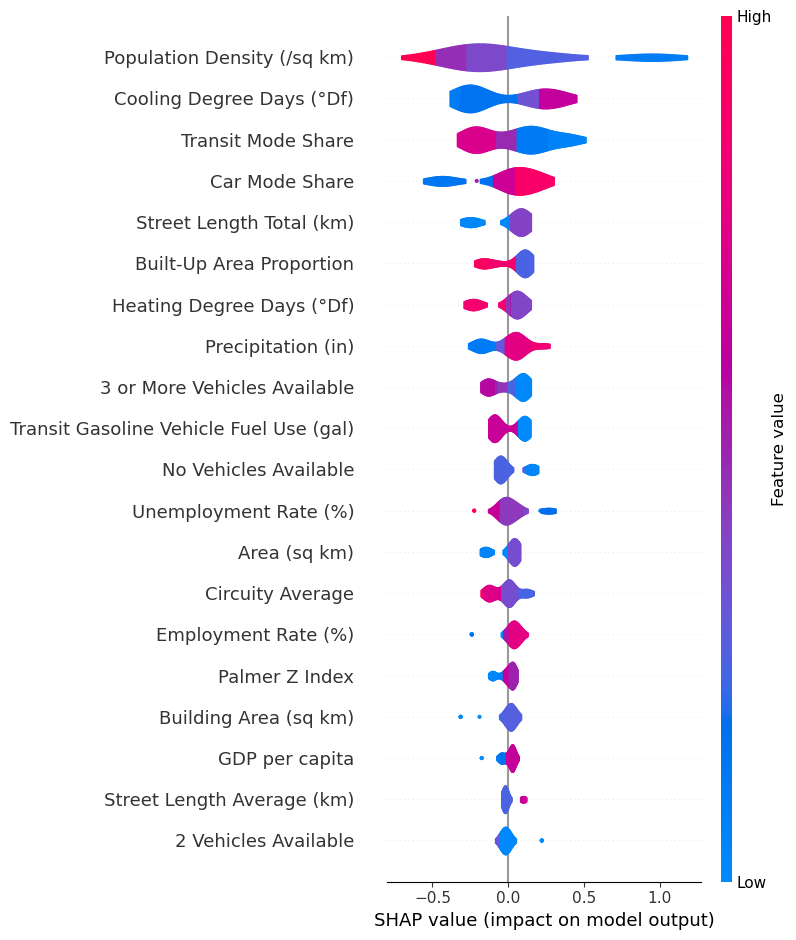

In [49]:
# Updated train_and_evaluate function to return SHAP values
def train_and_evaluate(X, y, param_grid, test_size=0.15, random_state=42):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Create the XGBoost regressor
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', use_label_encoder=False)
    
    # Use GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
        cv=5,  # 5-fold cross-validation
        verbose=1,
        n_jobs=-1  # Use all processors for parallel processing
    )
    
    # Fit the model on the training data
    grid_search.fit(X_train, y_train)
    grid_search_summary = pd.DataFrame(grid_search.cv_results_)
    top_10_estimators = grid_search_summary.sort_values(by='mean_test_score', ascending=False).head(20)
    
    # # Show the grid search summary
    # grid_search_summary = pd.DataFrame(grid_search.cv_results_)
    # # Sort the results by 'rank_test_score' (best score first) and select the top 10
    # top_10_grid_search = grid_search_summary[['param_max_depth', 'param_learning_rate', 'param_n_estimators', 'param_gamma', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head(10)
    
    # Train the final model with the best hyperparameters
    best_model = grid_search.best_estimator_
    
    # Predict on both training and test sets
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Calculate error metrics for the training set
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mse_train)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
    
    # Calculate error metrics for the test set
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
    
    # Compute validation error
    cv_results = grid_search.cv_results_
    mean_validation_error = -grid_search.best_score_  # Negate as scoring is reversed
    
    # Return necessary information
    return (
        X_train, y_train, y_train_pred, y_test, y_test_pred,
        r2_train, mape_train, rmse_train, mse_train, mae_train,
        r2_test, mape_test, rmse_test, mse_test, mae_test,
        X_test, best_model, grid_search.best_params_, mean_validation_error, cv_results,top_10_estimators
    )

# Define the parameter grid to search over
param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 6],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7],
    'n_estimators': [50, 100, 150, 200, 250],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}


raw['Cluster'] = raw['Cluster'].astype('category')


X = pd.get_dummies(raw.drop(columns=['msa', 'Cluster', 'Population', 'GDP ($)']), drop_first=False)

# data_to_standardize_after['Cluster'] = data_to_standardize_after['Cluster'].astype('category')


# X = pd.get_dummies(data_to_standardize_after.drop(columns=['msa', 'Cluster', 'Population', 'GDP ($)']), drop_first=False)

# Define a dictionary to store the results
results = {}

# Iterate over the different target variables (only emissions)
target = 'Emissions per capita (MTCO2e)'

# Assuming 'new_df' is your DataFrame containing this target
y = new_df[target]

(
    X_train, y_train, y_train_pred, y_test, y_test_pred,
    r2_train, mape_train, rmse_train, mse_train, mae_train,
    r2_test, mape_test, rmse_test, mse_test, mae_test,
    X_test, best_model, best_params, validation_error, cv_results,top_10_estimators
) = train_and_evaluate(X, y, param_grid)

# Store the results for both training and test sets
results['Training'] = {
    'R^2': r2_train, 
    'MAPE': mape_train, 
    'RMSE': rmse_train, 
    'MSE': mse_train, 
    'MAE': mae_train
}
results['Test'] = {
    'R^2': r2_test, 
    'MAPE': mape_test, 
    'RMSE': rmse_test, 
    'MSE': mse_test, 
    'MAE': mae_test
}

# Convert results to a DataFrame
results_df_without_cluster = pd.DataFrame(results)

# Print the results DataFrame
print(results_df_without_cluster)

# SHAP Analysis (outside of the function)
# Initialize the SHAP explainer for the best model
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)

fig = plt.figure(figsize=(16, 12))

shap.summary_plot(shap_values, X_test, plot_type="violin")
fig.savefig('../../figures/EPC_shap_summary_plot_violin.jpg', dpi=600)

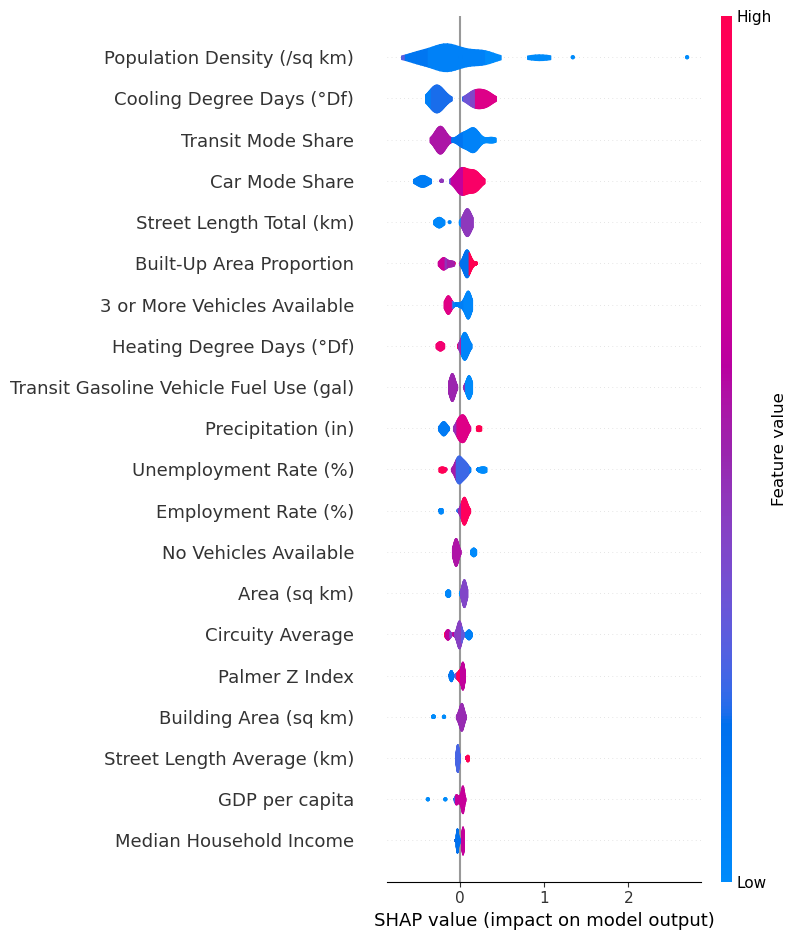

In [50]:
# Ensure X_combined matches the training data structure
X_combined = pd.concat([X_train, X_test])
X_combined['Cluster'] = pd.concat([
    raw['Cluster'].loc[X_train.index],
    raw['Cluster'].loc[X_test.index]
])

# Drop 'Cluster' column and ensure feature alignment
X_combined_features = X_combined.drop(columns=['Cluster'])

fig = plt.figure(figsize=(16, 12))

explainer = shap.Explainer(best_model, X_combined)
shap_values = explainer(X_combined)

shap.summary_plot(shap_values, X_combined, plot_type="violin")
fig.savefig('../../figures/entire-dataset-summary-plot.jpg', dpi=600)

<h1 style="font-size: 32px;">SHAP Value of each Cluster Type</h1>

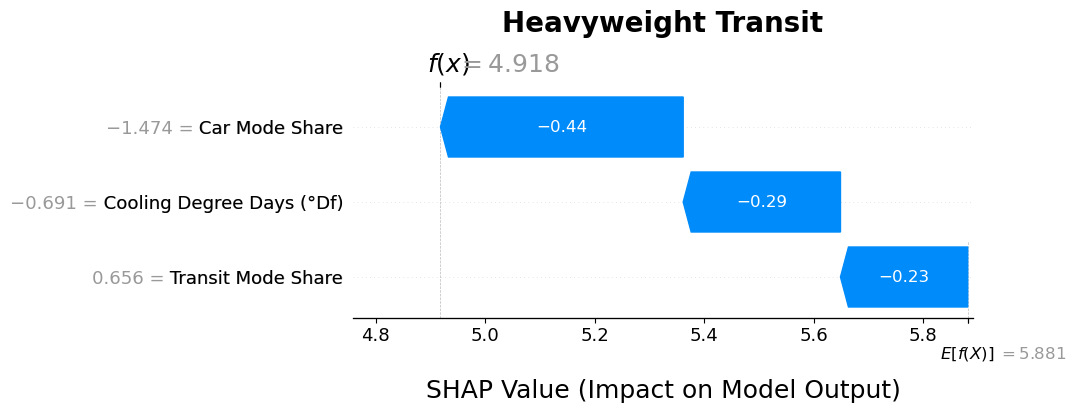

In [51]:

original_shap_value = shap_values[224]

# Get the absolute values of the SHAP values for ranking
absolute_values = np.abs(original_shap_value.values)

# Get indices of the top 3 features with the largest absolute SHAP values
top_indices = np.argsort(absolute_values)[::-1][:3]

# Select the top 3 features based on these indices
shap_values_limited = shap.Explanation(
    values=original_shap_value.values[top_indices],
    base_values=original_shap_value.base_values,
    data=original_shap_value.data[top_indices],
    feature_names=[original_shap_value.feature_names[i] for i in top_indices]
)

# Generate SHAP waterfall plot with ranked features
fig, ax = plt.subplots(figsize=(12, 8))
canvas = FigureCanvas(fig)
shap.plots.waterfall(shap_values_limited, show=False)


# Access and modify the original SHAP plot
plt.xticks(fontsize=18)  # Increase font size for x-axis ticks
plt.yticks(fontsize=18)  # Increase font size for y-axis ticks
plt.ylabel("Feature Names", fontsize=25)  # Increase font size for y-axis label
plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=18, labelpad=-250)  # Add padding to push label down
plt.title("Heavyweight Transit", fontsize=20, y=1.2,fontweight='bold')  # Add title under x-axis

# Save the modified plot
canvas.print_figure('../../figures/transit-dense-summary-plot-beeswarm.jpg', dpi=600, bbox_inches='tight')

# Show the plot
plt.show()


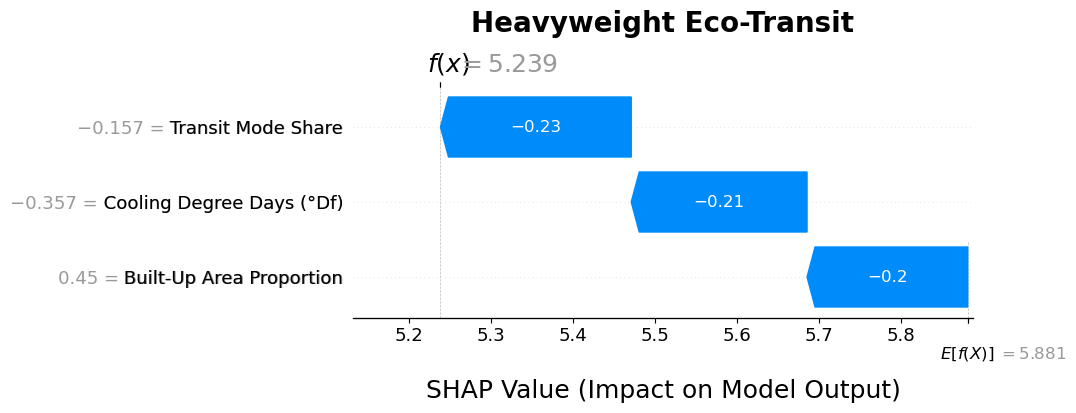

In [52]:


# Assuming `shap_values` is already generated and is an instance of shap.Explanation
# Extract the specific instance for which you want to create the waterfall plot
original_shap_value = shap_values[190]

# Get the absolute values of the SHAP values for ranking
absolute_values = np.abs(original_shap_value.values)

# Get indices of the top 3 features with the largest absolute SHAP values
top_indices = np.argsort(absolute_values)[::-1][:3]

# Select the top 3 features based on these indices
shap_values_limited = shap.Explanation(
    values=original_shap_value.values[top_indices],
    base_values=original_shap_value.base_values,
    data=original_shap_value.data[top_indices],
    feature_names=[original_shap_value.feature_names[i] for i in top_indices]
)

# Generate SHAP waterfall plot with ranked features
fig, ax = plt.subplots(figsize=(12, 8))
canvas = FigureCanvas(fig)
shap.plots.waterfall(shap_values_limited, show=False)

# Access and modify the original SHAP plot
plt.xticks(fontsize=18)  # Increase font size for x-axis ticks
plt.yticks(fontsize=18)  # Increase font size for y-axis ticks
plt.ylabel("Feature Names", fontsize=25)  # Increase font size for y-axis label
plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=18, labelpad=-250)  # Add padding to push label down
plt.title("Heavyweight Eco-Transit", fontsize=20, y=1.2,fontweight='bold')  # Add title under x-axis


# Save the modified plot
canvas.print_figure('../../figures/Eco-Transit Sprawl-summary-plot-beeswarm.jpg', dpi=600, bbox_inches='tight')


# Show the plot
plt.show()


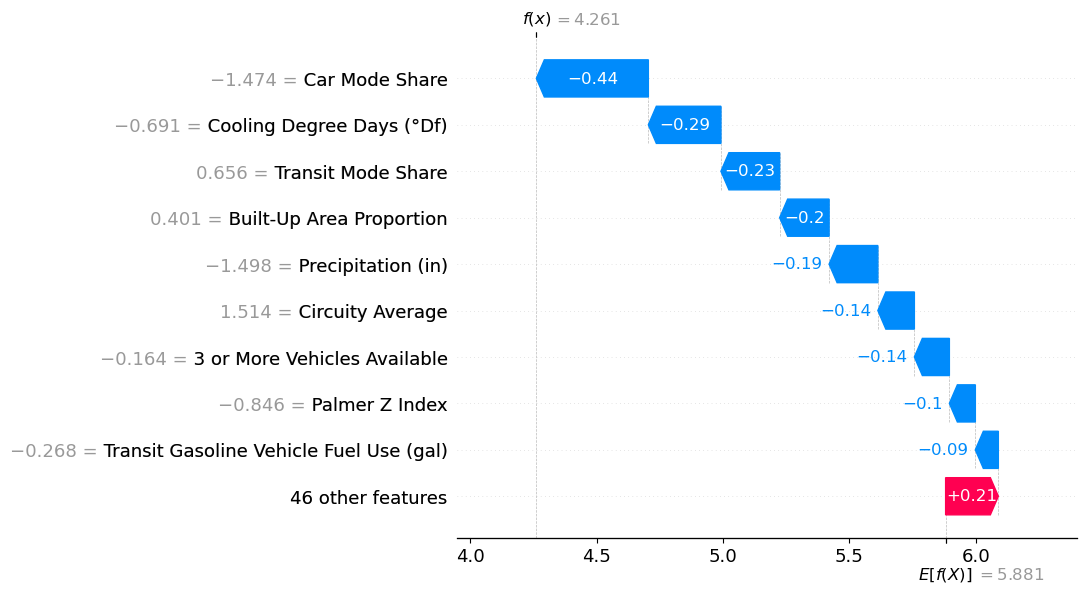

In [53]:

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

# Create a figure and attach it to a canvas
fig, ax = plt.subplots(figsize=(16, 12))
canvas = FigureCanvas(fig)

# Generate SHAP plot
shap.plots.waterfall(shap_values[224])

# Save the canvas as an image
# canvas.print_figure('../../figures/transit-dense-summary-plot-beeswarm.jpg', dpi=600, bbox_inches='tight')


In [54]:
# Dictionary to store DataFrames for each cluster
cluster_dataframes = {}

# Loop through each unique cluster value
for cluster in X_combined['Cluster'].unique():
    # Filter the rows corresponding to the current cluster
    cluster_dataframes[cluster] = X_combined[X_combined['Cluster'] == cluster]

X_combined_features_1 = cluster_dataframes[1].drop(columns=['Cluster'])
X_combined_features_2 = cluster_dataframes[2].drop(columns=['Cluster'])
X_combined_features_3 = cluster_dataframes[3].drop(columns=['Cluster'])
X_combined_features_4 = cluster_dataframes[4].drop(columns=['Cluster'])
X_combined_features_5 = cluster_dataframes[5].drop(columns=['Cluster'])
X_combined_features_6 = cluster_dataframes[6].drop(columns=['Cluster'])
X_combined_features_7 = cluster_dataframes[7].drop(columns=['Cluster'])

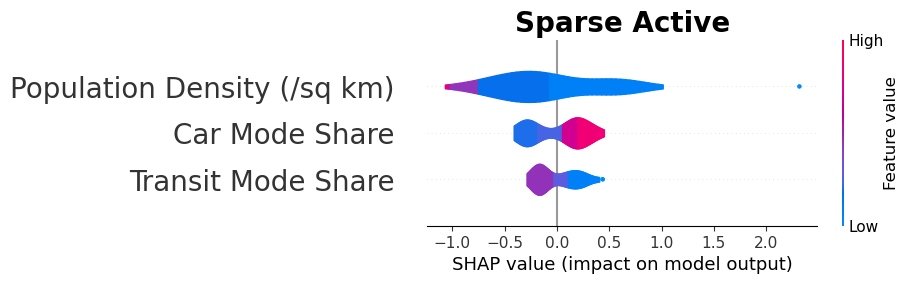

In [55]:


# Generate the SHAP plot
explainer = shap.Explainer(best_model, X_combined_features_1, feature_names=X_combined_features_1.columns)
shap_values = explainer(X_combined_features_1)

# Create the SHAP summary plot (do not show immediately)
shap.summary_plot(shap_values, X_combined_features_1, plot_type="violin", max_display=3, show=False)

# Get the current figure
fig = plt.gcf()

# **Fix: Manually adjust feature label font sizes**
for text in fig.findobj(plt.Text):
    if text.get_text() in X_combined_features_1.columns:  # If text is a feature name
        text.set_fontsize(20)  # Increase font size
        #text.set_weight('bold')  # Make bold
        #text.set_fontname("Times New Roman")  # Set font

plt.title("Sparse Active", fontsize=20, fontweight="bold")

# Save the figure with adjustments
fig.savefig('../../figures/Active-hybrid-summary-plot.jpg', dpi=600, bbox_inches='tight')

# Show the updated plot
plt.show()


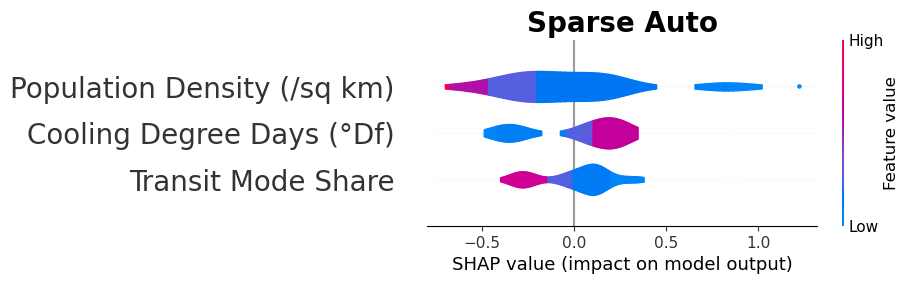

In [56]:


# Generate the SHAP plot
explainer = shap.Explainer(best_model, X_combined_features_3, feature_names=X_combined_features_3.columns)
shap_values = explainer(X_combined_features_3)

# Create the SHAP summary plot (do not show immediately)
shap.summary_plot(shap_values, X_combined_features_3, plot_type="violin", max_display=3, show=False)

# Get the current figure
fig = plt.gcf()

# **Fix: Manually adjust feature label font sizes**
for text in fig.findobj(plt.Text):
    if text.get_text() in X_combined_features_3.columns:  # If text is a feature name
        text.set_fontsize(20)  # Increase font size
        #text.set_weight('bold')  # Make bold
        #text.set_fontname("Times New Roman")  # Set font

plt.title("Sparse Auto", fontsize=20, fontweight="bold")

# Save the figure with adjustments
fig.savefig('../../figures/Auto-Connected-summary-plot.jpg', dpi=600, bbox_inches='tight')

# Show the updated plot
plt.show()


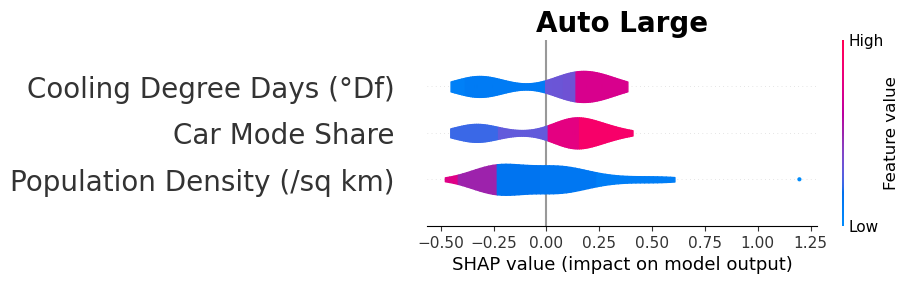

In [57]:


# Generate the SHAP plot
explainer = shap.Explainer(best_model, X_combined_features_4, feature_names=X_combined_features_4.columns)
shap_values = explainer(X_combined_features_4)

# Create the SHAP summary plot (do not show immediately)
shap.summary_plot(shap_values, X_combined_features_4, plot_type="violin", max_display=3, show=False)

# Get the current figure
fig = plt.gcf()

# **Fix: Manually adjust feature label font sizes**
for text in fig.findobj(plt.Text):
    if text.get_text() in X_combined_features_4.columns:  # If text is a feature name
        text.set_fontsize(20)  # Increase font size
        #text.set_weight('bold')  # Make bold
        #text.set_fontname("Times New Roman")  # Set font

plt.title("Auto Large", fontsize=20, fontweight="bold")

# Save the figure with adjustments
fig.savefig('../../figures/Auto-Dense-summary-plot.jpg', dpi=600, bbox_inches='tight')

# Show the updated plot
plt.show()


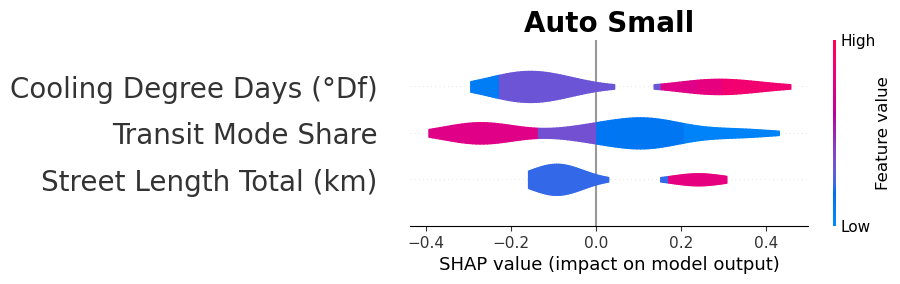

In [58]:


# Generate the SHAP plot
explainer = shap.Explainer(best_model, X_combined_features_5, feature_names=X_combined_features_5.columns)
shap_values = explainer(X_combined_features_5)

# Create the SHAP summary plot (do not show immediately)
shap.summary_plot(shap_values, X_combined_features_5, plot_type="violin", max_display=3, show=False)

# Get the current figure
fig = plt.gcf()

# **Fix: Manually adjust feature label font sizes**
for text in fig.findobj(plt.Text):
    if text.get_text() in X_combined_features_5.columns:  # If text is a feature name
        text.set_fontsize(20)  # Increase font size
        #text.set_weight('bold')  # Make bold
        #text.set_fontname("Times New Roman")  # Set font

plt.title("Auto Small", fontsize=20, fontweight="bold")

# Save the figure with adjustments
fig.savefig('../../figures/Auto-Moderate-summary-plot.jpg', dpi=600, bbox_inches='tight')

# Show the updated plot
plt.show()


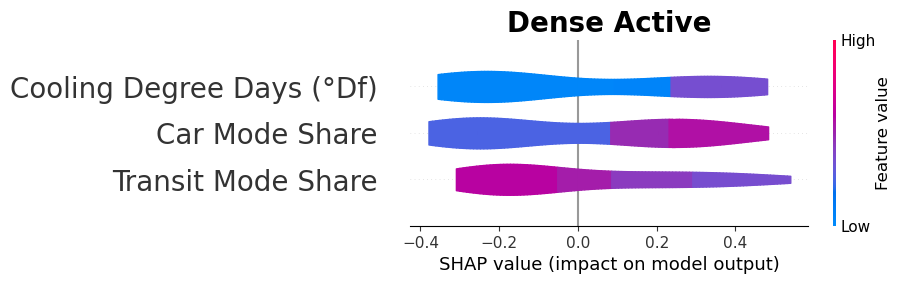

In [59]:


# Generate the SHAP plot
explainer = shap.Explainer(best_model, X_combined_features_7, feature_names=X_combined_features_7.columns)
shap_values = explainer(X_combined_features_7)

# Create the SHAP summary plot (do not show immediately)
shap.summary_plot(shap_values, X_combined_features_7, plot_type="violin", max_display=3, show=False)

# Get the current figure
fig = plt.gcf()

# **Fix: Manually adjust feature label font sizes**
for text in fig.findobj(plt.Text):
    if text.get_text() in X_combined_features_7.columns:  # If text is a feature name
        text.set_fontsize(20)  # Increase font size
        #text.set_weight('bold')  # Make bold
        #text.set_fontname("Times New Roman")  # Set font

plt.title("Dense Active", fontsize=20, fontweight="bold")

# Save the figure with adjustments
fig.savefig('../../figures/Active-Dense-summary-plot.jpg', dpi=600, bbox_inches='tight')

# Show the updated plot
plt.show()


<h1 style="font-size: 32px;">Predicted vs Observed Emissions</h1>

In [60]:
cluster_mapping = {
    4: 'Auto Large',
    5: 'Auto Small',
    7: 'Dense Active',
    6: 'Heavyweight Eco-Transit',
    2: 'Heavyweight Transit',
    1: 'Sparse Active',
    3: 'Sparse Auto'
}


cluster_labels = cluster_mapping 

# Order of cluster numbers in cluster_mapping
cluster_order = [4, 5, 7, 6, 2, 1, 3]

# Custom palette
custom_palette = ['#FDBF6F', '#FF7F00', '#1F78B4', '#B2DF8A', '#33A02C', '#FB9A99', '#E31A1C']

# Map the custom palette to the cluster order
ordered_palette = [custom_palette[cluster_order.index(cluster)] for cluster in sorted(cluster_mapping.keys())]

ordered_palette

['#FB9A99', '#33A02C', '#E31A1C', '#FDBF6F', '#FF7F00', '#B2DF8A', '#1F78B4']

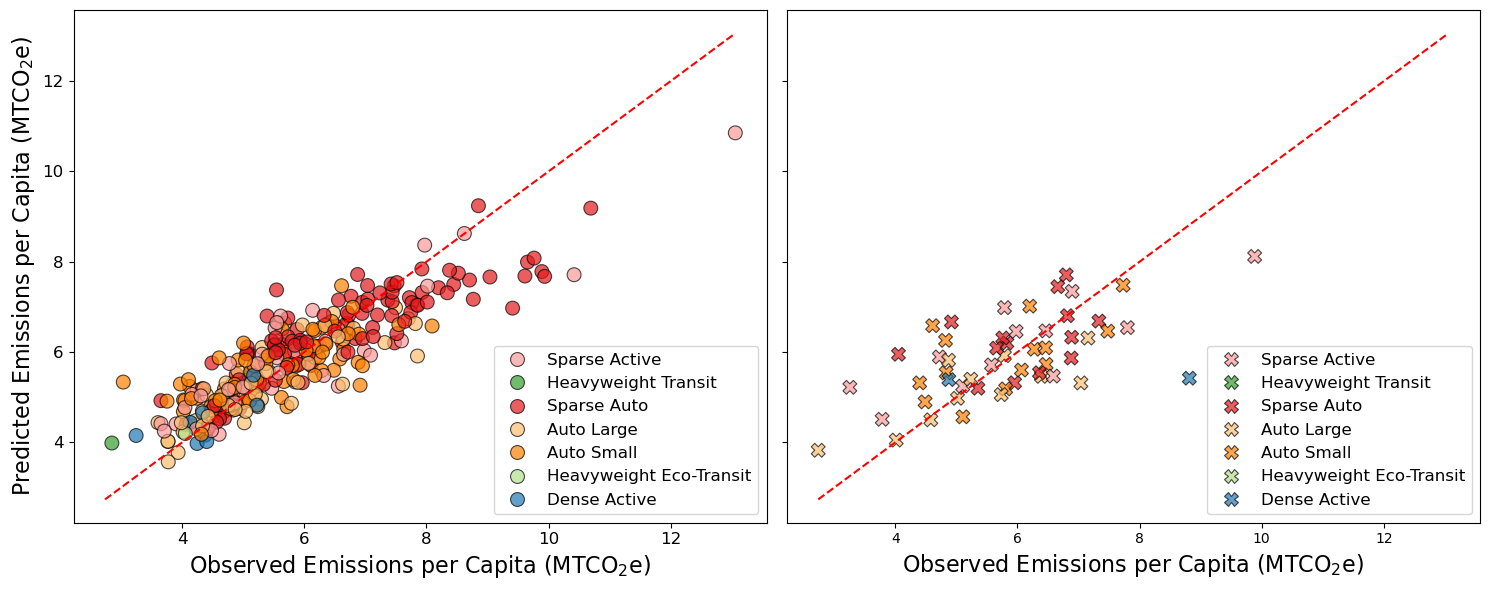

In [61]:
# Ensure 'Cluster' column is in the test dataset
X_test['Cluster'] = raw.loc[X_test.index, 'Cluster']
X_train['Cluster'] = raw.loc[X_train.index, 'Cluster']

# Create DataFrames for both training and test sets
vis_train_df = X_train.copy()
vis_train_df['Actual Emissions'] = y_train
vis_train_df['Predicted Emissions'] = y_train_pred

vis_test_df = X_test.copy()
vis_test_df['Actual Emissions'] = y_test
vis_test_df['Predicted Emissions'] = y_test_pred

# Define a custom color palette for clusters
#custom_palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f','#e5c494']
color_iter = ListedColormap(ordered_palette)



# Calculate R-squared for training and test sets
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Create a 1x2 grid of subplots (1 row, 2 columns)
fig, (ax_train, ax_test) = plt.subplots(1, 2, figsize=(15, 6))

# Plot training set
sns.scatterplot(data=vis_train_df, x='Actual Emissions', y='Predicted Emissions', hue='Cluster', 
                palette=ordered_palette, alpha=0.7, ax=ax_train, edgecolor='black', s=100, marker='o')

# Plot test set
sns.scatterplot(data=vis_test_df, x='Actual Emissions', y='Predicted Emissions', hue='Cluster', 
                palette=ordered_palette, alpha=0.7, ax=ax_test, edgecolor='black', s=100, marker='X')

# Add R-squared annotations for training and test sets
# ax_train.annotate(f'R² = {r2_train:.2f}', xy=(0.1, 0.85), xycoords='axes fraction', fontsize=15,
#                  bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))
# ax_test.annotate(f'R² = {r2_test:.2f}', xy=(0.1, 0.85), xycoords='axes fraction', fontsize=15,
#                  bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

# Add 1:1 line to both plots but exclude from legend
for ax in [ax_train, ax_test]:
    ax.plot([min(vis_train_df['Actual Emissions'].min(), vis_test_df['Actual Emissions'].min()), 
             max(vis_train_df['Actual Emissions'].max(), vis_test_df['Actual Emissions'].max())], 
            [min(vis_train_df['Actual Emissions'].min(), vis_test_df['Actual Emissions'].min()), 
             max(vis_train_df['Actual Emissions'].max(), vis_test_df['Actual Emissions'].max())], 
            color='red', linestyle='--', label='_nolegend_')  # '_nolegend_' ensures it is not included in the legend

# Set labels and ticks for both plots
# Set labels for training set plot
ax_train.set_xlabel('Observed Emissions per Capita (MTCO$_2$e)', fontsize=16)
ax_train.set_ylabel('Predicted Emissions per Capita (MTCO$_2$e)', fontsize=16)
ax_train.tick_params(axis='both', which='major', labelsize=12)

# Set labels for test set plot
ax_test.set_xlabel('Observed Emissions per Capita (MTCO$_2$e)', fontsize=16)
ax_test.set_ylabel('')  # Remove the y-axis label for the test plot
ax_test.set_yticklabels([])  # Remove the y-axis ticks for the test plot

# Update legends for both plots
handles_train, labels_train = ax_train.get_legend_handles_labels()
handles_test, labels_test = ax_test.get_legend_handles_labels()

# Create a mapping of labels to cluster labels
label_mapping = {str(i): name for i, name in cluster_labels.items()}
new_labels_train = [label_mapping.get(label, label) for label in labels_train]
new_labels_test = [label_mapping.get(label, label) for label in labels_test]

# Remove the title "Cluster" and the 1:1 line from the legend
# Update the legend for training set (on ax_train)
ax_train.legend(handles=handles_train, labels=new_labels_train, loc='lower right', fontsize=12, title=None)

# Update the legend for test set (on ax_test)
ax_test.legend(handles=handles_test, labels=new_labels_test, loc='lower right', fontsize=12, title=None)

# Adjust layout for better spacing
plt.tight_layout()

# Clear the current figure and save it after layout adjustment

plt.savefig('../../figures/EPC-actual-predicted-emissions-train-test-1x2.jpg', dpi=600)
plt.show()

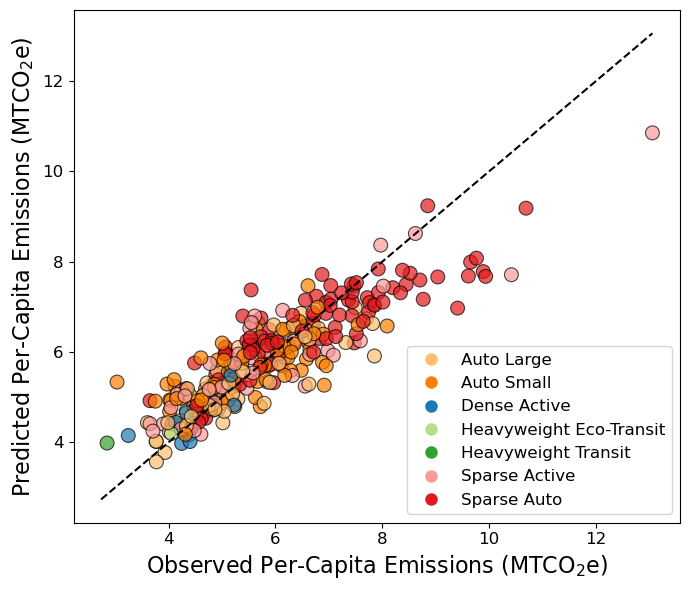

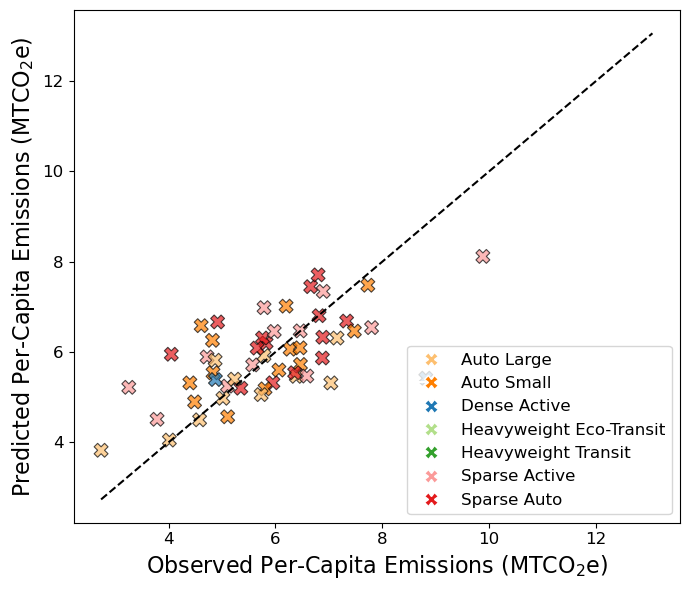

In [62]:


# Define custom color palette for clusters (corresponding to your color mapping)
ordered_palette = ['#FDBF6F', '#FF7F00', '#1F78B4', '#B2DF8A', '#33A02C', '#FB9A99', '#E31A1C']
color_iter = ListedColormap(ordered_palette)

# Cluster label mapping
cluster_labels = {
    1: 'Sparse Active',
    2: 'Heavyweight Transit',
    3: 'Sparse Auto',
    4: 'Auto Large',
    5: 'Auto Small',
    6: 'Heavyweight Eco-Transit',
    7: 'Dense Active'
}

# Define the manual color mapping
cluster_mapping = {
    4: 'Auto Large',
    5: 'Auto Small',
    7: 'Dense Active',
    6: 'Heavyweight Eco-Transit',
    2: 'Heavyweight Transit',
    1: 'Sparse Active',
    3: 'Sparse Auto'
}

# Define the corresponding colors for the clusters
color_mapping = {
    4: '#FDBF6F',  # Auto Large
    5: '#FF7F00',  # Auto Small
    7: '#1F78B4',  # Dense Active
    6: '#B2DF8A',  # Heavyweight Eco-Transit
    2: '#33A02C',  # Heavyweight Transit
    1: '#FB9A99',  # Sparse Active
    3: '#E31A1C'   # Sparse Auto
}

# Calculate R-squared for training and test sets
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Get min and max values for the 1:1 reference line
min_val = min(vis_train_df['Actual Emissions'].min(), vis_test_df['Actual Emissions'].min())
max_val = max(vis_train_df['Actual Emissions'].max(), vis_test_df['Actual Emissions'].max())

### Training Set Plot ###
fig_train, ax_train = plt.subplots(figsize=(7, 6))

# Plot the training set with scatterplot
sns.scatterplot(
    data=vis_train_df, x='Actual Emissions', y='Predicted Emissions', hue='Cluster', 
    palette=color_mapping, alpha=0.7, ax=ax_train, edgecolor='black', s=100, marker='o'
)

# Add 1:1 line for training set
ax_train.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', label='_nolegend_')

# Set labels and tick sizes
ax_train.set_xlabel('Observed Per-Capita Emissions (MTCO$_2$e)', fontsize=16)
ax_train.set_ylabel('Predicted Per-Capita Emissions (MTCO$_2$e)', fontsize=16)
ax_train.tick_params(axis='both', which='major', labelsize=12)

# Create custom legend using the manual color mapping and ensure marker matches
legend_elements_train = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[cluster], markersize=10, label=cluster_labels[cluster])
    for cluster in [4, 5, 7, 6, 2, 1, 3]
]

# Add the legend inside the plot (lower right)
ax_train.legend(
    handles=legend_elements_train, 
    loc='lower right', 
    fontsize=12, 
    title=None
)

# # Add R² annotation
# ax_train.text(0.05, 0.95, f'$R^2$ (Train): {r2_train:.2f}', transform=ax_train.transAxes,
#               fontsize=14, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Save the training plot
plt.tight_layout()
plt.savefig('../../figures/EPC-actual-predicted-emissions-train.jpg', dpi=600)


### Test Set Plot ###
fig_test, ax_test = plt.subplots(figsize=(7, 6))

# Plot the test set with scatterplot
sns.scatterplot(
    data=vis_test_df, x='Actual Emissions', y='Predicted Emissions', hue='Cluster', 
    palette=color_mapping, alpha=0.7, ax=ax_test, edgecolor='black', s=100, marker='X'
)

# Add 1:1 line for test set
ax_test.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', label='_nolegend_')

# Set labels and tick sizes
ax_test.set_xlabel('Observed Per-Capita Emissions (MTCO$_2$e)', fontsize=16)
ax_test.set_ylabel('Predicted Per-Capita Emissions (MTCO$_2$e)', fontsize=16)
ax_test.tick_params(axis='both', which='major', labelsize=12)

# Create custom legend using the manual color mapping and ensure marker matches (use 'X' marker for test plot)
legend_elements_test = [
    Line2D([0], [0], marker='X', color='w', markerfacecolor=color_mapping[cluster], markersize=10, label=cluster_labels[cluster])
    for cluster in [4, 5, 7, 6, 2, 1, 3]
]

# Add the legend inside the plot (lower right)
ax_test.legend(
    handles=legend_elements_test, 
    loc='lower right', 
    fontsize=12, 
    title=None
)

# # Add R² annotation
# ax_test.text(0.05, 0.95, f'$R^2$ (Test): {r2_test:.2f}', transform=ax_test.transAxes,
#              fontsize=14, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Save the test plot
plt.tight_layout()
plt.savefig('../../figures/EPC-actual-predicted-emissions-test.jpg', dpi=600)
plt.show()


In [63]:
# Assuming your DataFrame is named 'df'
raw['Cluster Name'] = raw['Cluster'].map(cluster_labels)


raw_original['Cluster']=raw['Cluster']
raw_original['Cluster Name']=raw['Cluster Name']

In [64]:
raw_original

,msa,Node Count,Edge Count,Degree Average,Edge Length Total (km),Edge Length Average (km),Streets per Node Average,Intersection Count,Street Length Total (km),Street Segment Count,...,Cooling Degree Days (°Df),Heating Degree Days (°Df),Palmer Z Index,Average Temperature (°F),Precipitation (in),Population Density (/sq km),Built-Up Area Proportion,Cluster,GDP per capita,Cluster Name
0,"Abilene, TX",14357.0,39401.0,5.488751,17168.965935,0.435749,2.881452,11912.0,8925.436120,20606.0,...,2383.00,2332.000000,0.340000,65.000000,27.356667,24.019917,5.944727,3,55.139063,Sparse Auto
1,"Akron, OH",26865.0,70900.0,5.278243,15191.985931,0.214273,2.756896,21200.0,8039.294972,36980.0,...,823.00,5338.000000,0.165000,52.500000,40.550000,294.018910,38.222028,7,60.130647,Dense Active
2,"Albany, GA",8466.0,22838.0,5.395228,9545.102272,0.417948,2.837468,6957.0,4989.592979,11954.0,...,2546.75,1526.000000,0.547500,67.725000,58.845000,35.333378,9.334387,3,49.579763,Sparse Auto
3,"Albany-Lebanon, OR",7132.0,17906.0,5.021312,8280.294430,0.462431,2.568144,5101.0,4225.438910,9147.0,...,163.00,5550.000000,-0.350000,50.200000,65.670000,21.285743,3.662438,1,44.580108,Sparse Active
4,"Albany-Schenectady-Troy, NY",36977.0,96867.0,5.239311,27872.441864,0.287739,2.755794,30254.0,14555.424691,50900.0,...,529.40,6367.200000,-0.396000,48.860000,37.660000,118.206895,15.468786,3,88.894160,Sparse Auto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,"Yakima, WA",10920.0,28902.0,5.293407,14155.026874,0.489759,2.709982,8275.0,7249.500452,14773.0,...,254.00,6455.000000,-0.860000,47.900000,22.810000,22.459825,20.914166,3,51.353993,Sparse Auto
345,"York-Hanover, PA",16622.0,44476.0,5.351462,13291.255851,0.298841,2.781194,13507.0,6831.204674,23064.0,...,1050.00,4662.000000,-0.220000,55.000000,42.820000,189.847748,19.615869,5,53.800310,Auto Small
346,"Youngstown-Warren-Boardman, OH-PA",24885.0,66650.0,5.356641,19738.540791,0.296152,2.794736,19982.0,10381.621775,34674.0,...,643.00,5695.333333,0.783333,51.033333,45.596667,119.182102,20.344176,3,43.504818,Sparse Auto
347,"Yuba City, CA",8419.0,21665.0,5.146692,7925.868395,0.365837,2.678465,6360.0,4094.273240,11260.0,...,1969.50,2338.000000,-1.580000,63.950000,12.295000,53.631459,4.979487,5,53.258406,Auto Small


In [72]:
raw_original['GDP per Capita']=raw_original['GDP ($)']/raw_original['Population']
raw_original

,msa,Node Count,Edge Count,Degree Average,Edge Length Total (km),Edge Length Average (km),Streets per Node Average,Intersection Count,Street Length Total (km),Street Segment Count,...,Heating Degree Days (°Df),Palmer Z Index,Average Temperature (°F),Precipitation (in),Population Density (/sq km),Built-Up Area Proportion,Cluster,GDP per capita,Cluster Name,GDP per Capita
0,"Abilene, TX",14357.0,39401.0,5.488751,17168.965935,0.435749,2.881452,11912.0,8925.436120,20606.0,...,2332.000000,0.340000,65.000000,27.356667,24.019917,5.944727,3,55.139063,Sparse Auto,55.139063
1,"Akron, OH",26865.0,70900.0,5.278243,15191.985931,0.214273,2.756896,21200.0,8039.294972,36980.0,...,5338.000000,0.165000,52.500000,40.550000,294.018910,38.222028,7,60.130647,Dense Active,60.130647
2,"Albany, GA",8466.0,22838.0,5.395228,9545.102272,0.417948,2.837468,6957.0,4989.592979,11954.0,...,1526.000000,0.547500,67.725000,58.845000,35.333378,9.334387,3,49.579763,Sparse Auto,49.579763
3,"Albany-Lebanon, OR",7132.0,17906.0,5.021312,8280.294430,0.462431,2.568144,5101.0,4225.438910,9147.0,...,5550.000000,-0.350000,50.200000,65.670000,21.285743,3.662438,1,44.580108,Sparse Active,44.580108
4,"Albany-Schenectady-Troy, NY",36977.0,96867.0,5.239311,27872.441864,0.287739,2.755794,30254.0,14555.424691,50900.0,...,6367.200000,-0.396000,48.860000,37.660000,118.206895,15.468786,3,88.894160,Sparse Auto,88.894160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,"Yakima, WA",10920.0,28902.0,5.293407,14155.026874,0.489759,2.709982,8275.0,7249.500452,14773.0,...,6455.000000,-0.860000,47.900000,22.810000,22.459825,20.914166,3,51.353993,Sparse Auto,51.353993
345,"York-Hanover, PA",16622.0,44476.0,5.351462,13291.255851,0.298841,2.781194,13507.0,6831.204674,23064.0,...,4662.000000,-0.220000,55.000000,42.820000,189.847748,19.615869,5,53.800310,Auto Small,53.800310
346,"Youngstown-Warren-Boardman, OH-PA",24885.0,66650.0,5.356641,19738.540791,0.296152,2.794736,19982.0,10381.621775,34674.0,...,5695.333333,0.783333,51.033333,45.596667,119.182102,20.344176,3,43.504818,Sparse Auto,43.504818
347,"Yuba City, CA",8419.0,21665.0,5.146692,7925.868395,0.365837,2.678465,6360.0,4094.273240,11260.0,...,2338.000000,-1.580000,63.950000,12.295000,53.631459,4.979487,5,53.258406,Auto Small,53.258406


In [73]:
new_df 

,MSA,carbon dioxide equivalent (Ton),Auto + Scale,Transit Propensity,Density,Sustainable Transit,Warm Weather,Remote + Active,Network Connectivity,Network Sprawl,Cluster,Population,Emissions per capita,carbon dioxide equivalent (MMTCO2e),Emissions per capita (MTCO2e),carbon intensity by GDP
0,"Abilene, TX",1.604661e+06,-0.020769,-0.116631,-0.567720,-0.215719,1.024831,-0.196886,1.138187,1.305839,3,171354,9.364594,1.455724,8.521780,-4.873838e+06
1,"Akron, OH",4.038062e+06,-0.595251,-0.032704,2.367134,0.181770,-0.714500,-0.538529,0.487787,-0.200201,7,703286,5.741707,3.663268,5.224953,-4.179418e+07
2,"Albany, GA",1.062811e+06,-0.280811,0.056536,-0.590122,-0.044732,1.345877,-0.471593,0.828885,1.103606,3,147431,7.208870,0.964166,6.560072,-3.086079e+06
3,"Albany-Lebanon, OR",9.640033e+05,-0.234983,0.067162,-1.131492,0.029690,-0.738241,-0.138377,-0.912521,0.868893,1,127216,7.577689,0.874529,6.895697,-2.707925e+06
4,"Albany-Schenectady-Troy, NY",4.416599e+06,0.253770,-0.144994,0.279123,-0.278315,-1.043975,0.433586,0.400056,-0.411223,3,880766,5.014498,4.006672,4.563193,2.787836e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,"Yakima, WA",1.345779e+06,0.055568,-0.016343,-1.304796,-0.044245,-1.032406,-0.639057,0.115356,0.847270,3,250649,5.369176,1.220870,4.885950,-4.412539e+06
345,"York-Hanover, PA",2.087107e+06,-0.564581,0.064776,1.461622,0.149391,-0.349227,-0.563617,0.637335,0.441696,5,447628,4.662592,1.893391,4.242959,-9.252157e+06
346,"Youngstown-Warren-Boardman, OH-PA",3.089513e+06,-0.082061,-0.059134,0.624753,-0.157510,-0.896252,-0.966299,0.642194,-0.369812,3,538115,5.741362,2.802759,5.224640,-1.341283e+07
347,"Yuba City, CA",5.800871e+05,-0.398228,0.078186,-0.467446,-0.017681,0.861001,-0.215744,-0.064006,0.458856,5,173839,3.336922,0.526246,3.036599,-1.754730e+06


In [75]:
raw_original.columns

Index(['msa', 'Node Count', 'Edge Count', 'Degree Average',
       'Edge Length Total (km)', 'Edge Length Average (km)',
       'Streets per Node Average', 'Intersection Count',
       'Street Length Total (km)', 'Street Segment Count',
       'Street Length Average (km)', 'Circuity Average',
       'Self-loop Proportion', 'Node Density (/sq km)',
       'Intersection Density (/sq km)', 'Edge Density (km/sq km)',
       'Street Density (km/sq km)', 'Building Area (sq km)', 'Area (sq km)',
       'Car Mode Share', 'Transit Mode Share', 'Bicycle Mode Share',
       'Walking Mode Share', 'Working from Home Share',
       'Median Household Income', 'Households', 'Employment Rate (%)',
       'Unemployment Rate (%)', 'Population', 'Housing Units',
       'No Vehicles Available', '1 Vehicle Available', '2 Vehicles Available',
       '3 or More Vehicles Available', 'GDP ($)', 'Transit Diesel (gal)',
       'Transit Gasoline Vehicle Fuel Use (gal)',
       'Transit Liquefied Petroleum Gas (GGE

In [76]:
raw_original_emissions=raw_original 
raw_original_emissions['Emissions (MMTCO2e)']=new_df['carbon dioxide equivalent (MMTCO2e)']
raw_original_emissions['Per-capita Emissions (MMTCO2e)']=new_df['Emissions per capita (MTCO2e)']
raw_original_emissions

,msa,Node Count,Edge Count,Degree Average,Edge Length Total (km),Edge Length Average (km),Streets per Node Average,Intersection Count,Street Length Total (km),Street Segment Count,...,Average Temperature (°F),Precipitation (in),Population Density (/sq km),Built-Up Area Proportion,Cluster,GDP per capita,Cluster Name,GDP per Capita,Emissions (MMTCO2e),Per-capita Emissions (MMTCO2e)
0,"Abilene, TX",14357.0,39401.0,5.488751,17168.965935,0.435749,2.881452,11912.0,8925.436120,20606.0,...,65.000000,27.356667,24.019917,5.944727,3,55.139063,Sparse Auto,55.139063,1.455724,8.521780
1,"Akron, OH",26865.0,70900.0,5.278243,15191.985931,0.214273,2.756896,21200.0,8039.294972,36980.0,...,52.500000,40.550000,294.018910,38.222028,7,60.130647,Dense Active,60.130647,3.663268,5.224953
2,"Albany, GA",8466.0,22838.0,5.395228,9545.102272,0.417948,2.837468,6957.0,4989.592979,11954.0,...,67.725000,58.845000,35.333378,9.334387,3,49.579763,Sparse Auto,49.579763,0.964166,6.560072
3,"Albany-Lebanon, OR",7132.0,17906.0,5.021312,8280.294430,0.462431,2.568144,5101.0,4225.438910,9147.0,...,50.200000,65.670000,21.285743,3.662438,1,44.580108,Sparse Active,44.580108,0.874529,6.895697
4,"Albany-Schenectady-Troy, NY",36977.0,96867.0,5.239311,27872.441864,0.287739,2.755794,30254.0,14555.424691,50900.0,...,48.860000,37.660000,118.206895,15.468786,3,88.894160,Sparse Auto,88.894160,4.006672,4.563193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,"Yakima, WA",10920.0,28902.0,5.293407,14155.026874,0.489759,2.709982,8275.0,7249.500452,14773.0,...,47.900000,22.810000,22.459825,20.914166,3,51.353993,Sparse Auto,51.353993,1.220870,4.885950
345,"York-Hanover, PA",16622.0,44476.0,5.351462,13291.255851,0.298841,2.781194,13507.0,6831.204674,23064.0,...,55.000000,42.820000,189.847748,19.615869,5,53.800310,Auto Small,53.800310,1.893391,4.242959
346,"Youngstown-Warren-Boardman, OH-PA",24885.0,66650.0,5.356641,19738.540791,0.296152,2.794736,19982.0,10381.621775,34674.0,...,51.033333,45.596667,119.182102,20.344176,3,43.504818,Sparse Auto,43.504818,2.802759,5.224640
347,"Yuba City, CA",8419.0,21665.0,5.146692,7925.868395,0.365837,2.678465,6360.0,4094.273240,11260.0,...,63.950000,12.295000,53.631459,4.979487,5,53.258406,Auto Small,53.258406,0.526246,3.036599


In [78]:
raw_original_emissions.columns
raw_original_emissions.to_csv('../../data/tidy/msa-data.csv', index=False)

<h1 style="font-size: 32px;">Scatter-Variables & Cluster</h1>

In [ ]:


# Define custom color palette for clusters (corresponding to your color mapping)
ordered_palette = ['#FDBF6F', '#FF7F00', '#1F78B4', '#B2DF8A', '#33A02C', '#FB9A99', '#E31A1C']
color_iter = ListedColormap(ordered_palette)

# Cluster label mapping
cluster_labels = {
    1: 'Sparse Active',
    2: 'Heavyweight Transit',
    3: 'Sparse Auto',
    4: 'Auto Large',
    5: 'Auto Small',
    6: 'Heavyweight Eco-Transit',
    7: 'Dense Active'
}

# Define the manual color mapping
cluster_mapping = {
    4: 'Auto Large',
    5: 'Auto Small',
    7: 'Dense Active',
    6: 'Heavyweight Eco-Transit',
    2: 'Heavyweight Transit',
    1: 'Sparse Active',
    3: 'Sparse Auto'
}

# Define the corresponding colors for the clusters
color_mapping = {
    4: '#FDBF6F',  # Auto Large
    5: '#FF7F00',  # Auto Small
    7: '#1F78B4',  # Dense Active
    6: '#B2DF8A',  # Heavyweight Eco-Transit
    2: '#33A02C',  # Heavyweight Transit
    1: '#FB9A99',  # Sparse Active
    3: '#E31A1C'   # Sparse Auto
}

# Create the FacetGrid with scatter plots for each variable
g = sns.FacetGrid(
    melted_df, col='Variable', col_wrap=3, height=4, aspect=1.5,
    hue='Cluster', palette=color_mapping, sharex=False
)

# Map the scatterplot to the grid
g.map(
    sns.scatterplot, 'Value', 'Emissions per capita (MTCO2e)',
    edgecolor='black', alpha=0.8, s=80, marker='o'  # Specify marker style here
)

# Add annotations for top 4 outliers in both x and y directions for each variable
for ax, variable_name in zip(g.axes.flat, columns_to_plot):
    if variable_name in outliers_dict:
        x_outliers = outliers_dict[variable_name]['x_outliers']
        y_outliers = outliers_dict[variable_name]['y_outliers']
        
        # Collect annotation objects and arrows
        annotations = []
        
        # Annotate x-axis outliers
        for _, row in x_outliers.iterrows():
            x_value = row[variable_name]
            y_value = row['Emissions per capita (MTCO2e)']
            msa_label = re.split('[,-]', row['msa'])[0]  # Simplify MSA name
            
            # Shorten specific names
            if msa_label == "San Francisco":
                msa_label = "SF"
            elif msa_label == "New York":
                msa_label = "NY"
            elif msa_label == "Los Angeles":
                msa_label = "LA"
            
            # Add annotation with arrow
            annotations.append(ax.annotate(
                msa_label, 
                (x_value, y_value), 
                color='black', 
                fontsize=20, 
                ha='center', 
                va='center',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0),
                arrowprops=dict(arrowstyle="->", color='black', lw=1, mutation_scale=10)
            ))
        
        # Annotate y-axis outliers
        for _, row in y_outliers.iterrows():
            x_value = row[variable_name]
            y_value = row['Emissions per capita (MTCO2e)']
            msa_label = re.split('[,-]', row['msa'])[0]  # Simplify MSA name
            
            # Shorten specific names
            if msa_label == "San Francisco":
                msa_label = "SF"
            elif msa_label == "New York":
                msa_label = "NY"
            elif msa_label == "Los Angeles":
                msa_label = "LA"
            
            # Add annotation with arrow
            annotations.append(ax.annotate(
                msa_label, 
                (x_value, y_value), 
                color='black', 
                fontsize=17, 
                ha='center', 
                va='center',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0),
                arrowprops=dict(arrowstyle="->", color='black', lw=1, mutation_scale=10)
            ))

        # Use adjust_text to improve positioning
        adjust_text(annotations, ax=ax, expand_text=(1.5, 1.5), only_move={'points': 'xy'})

# Create custom legend manually to match the markers used in the scatter plot
# Update the order of the clusters to move 'Dense Active' to the end
handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[k], 
           markersize=20, label=cluster_mapping[k]) for k in [4, 5, 6, 2, 1, 3, 7]
]

# Add the legend manually outside the facet grid (centered at the bottom)
g.fig.legend(
    handles=handles, bbox_to_anchor=(0.5, -0.02), loc='upper center', 
    ncol=4, fontsize=23, frameon=False, title="Type", title_fontsize=25, labelspacing=1
)

# Remove the facet plot title completely
g.set_titles("")  # Remove titles from the facets

# Move the facet plot title to the x-axis label
g.set_axis_labels('Variable', 'Emissions Per Capita (MTCO$_2$e)', fontsize=18)

# Set the original facet title (column name) as the x-axis label
for ax, variable_name in zip(g.axes.flat, columns_to_plot):
    ax.set_xlabel(variable_name, fontsize=20, labelpad=15)  
    
    # Set log scale for both x and y axes
    ax.set_xscale('log')

# Adjust layout for spacing
g.fig.subplots_adjust(top=1.3, bottom=0.1, wspace=0.08, hspace=0.4)

# Adjust tick sizes
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)

# Save the figure
plt.savefig('../../figures/variable-emissions-scatter-3x2-with-top-4-outliers-xlog.jpg', dpi=1200, bbox_inches='tight')
plt.show()


<h1 style="font-size: 32px;">Variables & Factor Types by Cluster Type</h1>

In [ ]:


# Columns to plot
columns_to_plot = [
    '3 or More Vehicles Available',
    'Bicycle Mode Share',
    'Building Area (sq km)',
    'Built-Up Area Proportion',
    'Car Mode Share',
    'Cooling Degree Days (°Df)',
    'No Vehicles Available',
    'Population Density (/sq km)',
    'Street Density (km/sq km)',
    'Transit Diesel (gal)',
    'Transit Electric Battery Vehicle Fuel Use (kWh)',
    'Transit Mode Share'
]


# Cluster label and color mapping with Dense Active moved to the end
cluster_labels = {
    1: 'Sparse Active',
    2: 'Heavyweight Transit',
    3: 'Sparse Auto',
    4: 'Auto Large',
    5: 'Auto Small',
    6: 'Heavyweight Eco-Transit',
    7: 'Dense Active'
}

color_mapping = {
    'Auto Large': '#FDBF6F',
    'Auto Small': '#FF7F00',
    'Heavyweight Eco-Transit': '#B2DF8A',
    'Heavyweight Transit': '#33A02C',
    'Sparse Active': '#FB9A99',
    'Sparse Auto': '#E31A1C',
    'Dense Active': '#1F78B4'  # Dense Active at the end
}

# Ensure no NaNs in 'Cluster'
raw_clean = raw_original.dropna(subset=['Cluster'])

# Map cluster names
raw_original['Cluster Name'] = raw_original['Cluster'].map(cluster_labels)

# Convert to long format
pcdf_melt = raw_clean.melt(
    id_vars=['Cluster', 'Cluster Name'],
    value_vars=columns_to_plot,
    var_name='Variable',
    value_name='Value'
)

# Create FacetGrid
g = sns.FacetGrid(pcdf_melt, col='Variable', col_wrap=4, height=5, sharex=False, sharey=False)

# Plot boxen plots with custom colors in the specified order
g.map_dataframe(
    sns.boxenplot, 
    x='Cluster Name', 
    y='Value', 
    palette=color_mapping, 
    order=list(color_mapping.keys())  # Ensures Dense Active is last
)

# Set titles and remove x-axis labels
g.set_titles(col_template='{col_name}', size=20)
g.set_axis_labels('', '')  # Remove x-axis label

# Customize x-axis and y-axis ticks
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelsize=0)  # Hide x-axis labels
    ax.tick_params(axis='y', labelsize=12)
    
    ax.grid(True, which='both', axis='y', linestyle='--', linewidth=1, alpha=0.7)
    
# for ax in g.axes.flat:
#     ax.tick_params(axis='x', bottom=False)  # Disable x-axis ticks
#     #ax.spines['bottom'].set_visible(False)  # Hide the x-axis spine
    
    
for ax in g.axes.flat:
    ax.tick_params(axis='x', which='both', bottom=False, top=False)  # Remove major and minor ticks
    ax.set_xticks([])  # Ensure no ticks at all
    ax.spines['bottom'].set_visible(True)  # Hide x-axis line



# Manual legend creation in the specified order with Dense Active at the end
handles = [
    Line2D([0], [0], marker='s', color=color_mapping[label], label=label, markersize=15, linestyle='')
    for label in color_mapping.keys()
]

# Add the legend below the plot
g.fig.legend(
    handles=handles, 
    bbox_to_anchor=(0.5, -0.005),  # Position legend below the plot
    loc='upper center', 
    ncol=4, 
    title="Types", 
    title_fontsize='27', 
    fontsize='27', 
    frameon=False
)

# Wrap long titles for better readability
for ax in g.axes.flat:
    wrapped_title = textwrap.fill(ax.get_title(), width=28)
    ax.set_title(wrapped_title, fontsize=20)

# Adjust layout to ensure everything fits well
g.fig.subplots_adjust(bottom=0.03, hspace=0.2)

# Save the plot
facet_grid_path = '../../figures/EPC-variable-boxenplot-with-legend.jpg'
g.savefig(facet_grid_path, dpi=600, bbox_inches='tight')

# Show the plot
plt.show()


In [ ]:
# Assuming your DataFrame is named df
result = pcdf_melt[(pcdf_melt['Cluster Name'] == 'Heavyweight Transit') & (pcdf_melt['Variable'] == 'Car Mode Share')]

mean_value = result['Value'].median()
mean_value

In [ ]:


# Columns to plot
columns_to_plot = [
    '3 or More Vehicles Available',
    'Bicycle Mode Share',
    'Building Area (sq km)',
    'Built-Up Area Proportion',
    'Car Mode Share',
    'Cooling Degree Days (°Df)',
    'No Vehicles Available',
    'Population Density (/sq km)',
    'Street Density (km/sq km)',
    'Transit Diesel (gal)',
    'Transit Electric Battery Vehicle Fuel Use (kWh)',
    'Transit Mode Share'
]


# Cluster label and color mapping with Dense Active moved to the end
cluster_labels = {
    1: 'Sparse Active',
    2: 'Heavyweight Transit',
    3: 'Sparse Auto',
    4: 'Auto Large',
    5: 'Auto Small',
    6: 'Heavyweight Eco-Transit',
    7: 'Dense Active'
}

color_mapping = {
    'Auto Large': '#FDBF6F',
    'Auto Small': '#FF7F00',
    'Heavyweight Eco-Transit': '#B2DF8A',
    'Heavyweight Transit': '#33A02C',
    'Sparse Active': '#FB9A99',
    'Sparse Auto': '#E31A1C',
    'Dense Active': '#1F78B4'  # Dense Active at the end
}


columns_to_plot = [
    '1 Vehicle Available', '2 Vehicles Available', '3 or More Vehicles Available', 'Area (sq km)', 'Average Temperature (°F)', 'Bicycle Mode Share', 'Built-Up Area Proportion', 'Building Area (sq km)', 'Car Mode Share', 'Circuity Average', 'Cooling Degree Days (°Df)', 'Degree Average', 'Edge Count', 'Edge Density (km/sq km)', 'Edge Length Average (km)', 'Edge Length Total (km)', 'Employment Rate (%)', 'GDP ($)', 'Heating Degree Days (°Df)', 'Households', 'Housing Units', 'Intersection Count', 'Intersection Density (/sq km)', 'Median Household Income', 'Node Count', 'Node Density (/sq km)',
    'No Vehicles Available', 'Palmer Z Index', 'Population','Population Density (/sq km)'
]

# Ensure no NaNs in 'Cluster'
raw_clean = raw_original.dropna(subset=['Cluster'])

# Map cluster names
raw_original['Cluster Name'] = raw_original['Cluster'].map(cluster_labels)

# Convert to long format
pcdf_melt = raw_clean.melt(
    id_vars=['Cluster', 'Cluster Name'],
    value_vars=columns_to_plot,
    var_name='Variable',
    value_name='Value'
)

# Create FacetGrid
g = sns.FacetGrid(pcdf_melt, col='Variable', col_wrap=5, height=5, sharex=False, sharey=False)

# Plot boxen plots with custom colors in the specified order
g.map_dataframe(
    sns.boxenplot, 
    x='Cluster Name', 
    y='Value', 
    palette=color_mapping, 
    order=list(color_mapping.keys())  # Ensures Dense Active is last
)

# Set titles and remove x-axis labels
g.set_titles(col_template='{col_name}', size=20)
g.set_axis_labels('', '')  # Remove x-axis label

# Customize x-axis and y-axis ticks
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelsize=0)  # Hide x-axis labels
    ax.tick_params(axis='y', labelsize=12)

# Manual legend creation in the specified order with Dense Active at the end
handles = [
    Line2D([0], [0], marker='s', color=color_mapping[label], label=label, markersize=15, linestyle='')
    for label in color_mapping.keys()
]

# Add the legend below the plot
g.fig.legend(
    handles=handles, 
    bbox_to_anchor=(0.5, -0.005),  # Position legend below the plot
    loc='upper center', 
    ncol=4, 
    title="Types", 
    title_fontsize='27', 
    fontsize='27', 
    frameon=False
)

# Wrap long titles for better readability
for ax in g.axes.flat:
    wrapped_title = textwrap.fill(ax.get_title(), width=28)
    ax.set_title(wrapped_title, fontsize=20)

# Adjust layout to ensure everything fits well
g.fig.subplots_adjust(bottom=0.03, hspace=0.2)

# Save the plot
facet_grid_path = '../../figures/EPC-variable-boxenplot-with-legend-all-1.jpg'
g.savefig(facet_grid_path, dpi=600, bbox_inches='tight')

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import textwrap

# Columns to plot
columns_to_plot = [
    '3 or More Vehicles Available',
    'Bicycle Mode Share',
    'Building Area (sq km)',
    'Built-Up Area Proportion',
    'Car Mode Share',
    'Cooling Degree Days (°Df)',
    'No Vehicles Available',
    'Population Density (/sq km)',
    'Street Density (km/sq km)',
    'Transit Diesel (gal)',
    'Transit Electric Battery Vehicle Fuel Use (kWh)',
    'Transit Mode Share'
]


# Cluster label and color mapping with Dense Active moved to the end
cluster_labels = {
    1: 'Sparse Active',
    2: 'Heavyweight Transit',
    3: 'Sparse Auto',
    4: 'Auto Large',
    5: 'Auto Small',
    6: 'Heavyweight Eco-Transit',
    7: 'Dense Active'
}

color_mapping = {
    'Auto Large': '#FDBF6F',
    'Auto Small': '#FF7F00',
    'Heavyweight Eco-Transit': '#B2DF8A',
    'Heavyweight Transit': '#33A02C',
    'Sparse Active': '#FB9A99',
    'Sparse Auto': '#E31A1C',
    'Dense Active': '#1F78B4'  # Dense Active at the end
}


columns_to_plot = [
     'Precipitation (in)', 'Self-loop Proportion', 'Street Density (km/sq km)', 'Street Length Average (km)', 'Street Length Total (km)', 'Street Segment Count', 'Streets per Node Average', 'Transit Bio-Diesel (gal)', 'Transit Compressed Natural Gas (GGE)', 'Transit Compressed Natural Gas Vehicle Miles', 'Transit Diesel (gal)', 'Transit Diesel Vehicle Miles', 'Transit Electric Battery Vehicle Fuel Use (kWh)', 'Transit Electric Battery Vehicle Miles', 'Transit Electric Propulsion Vehicle Fuel Use (kWh)', 'Transit Electric Propulsion Vehicle Miles', 'Transit Gasoline Vehicle Fuel Use (gal)', 'Transit Gasoline Vehicle Miles', 'Transit Liquefied Petroleum Gas (GGE)', 'Transit Mode Share', 'Transit Other Fuel (GGE)', 'Transit Other Fuel Vehicle Miles', 'Unemployment Rate (%)', 'Walking Mode Share', 'Working from Home Share'
]

# Ensure no NaNs in 'Cluster'
raw_clean = raw_original.dropna(subset=['Cluster'])

# Map cluster names
raw_original['Cluster Name'] = raw_original['Cluster'].map(cluster_labels)

# Convert to long format
pcdf_melt = raw_clean.melt(
    id_vars=['Cluster', 'Cluster Name'],
    value_vars=columns_to_plot,
    var_name='Variable',
    value_name='Value'
)

# Create FacetGrid
g = sns.FacetGrid(pcdf_melt, col='Variable', col_wrap=5, height=5, sharex=False, sharey=False)

# Plot boxen plots with custom colors in the specified order
g.map_dataframe(
    sns.boxenplot, 
    x='Cluster Name', 
    y='Value', 
    palette=color_mapping, 
    order=list(color_mapping.keys())  # Ensures Dense Active is last
)

# Set titles and remove x-axis labels
g.set_titles(col_template='{col_name}', size=20)
g.set_axis_labels('', '')  # Remove x-axis label

# Customize x-axis and y-axis ticks
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelsize=0)  # Hide x-axis labels
    ax.tick_params(axis='y', labelsize=12)

# Manual legend creation in the specified order with Dense Active at the end
handles = [
    Line2D([0], [0], marker='s', color=color_mapping[label], label=label, markersize=15, linestyle='')
    for label in color_mapping.keys()
]

# Add the legend below the plot
g.fig.legend(
    handles=handles, 
    bbox_to_anchor=(0.5, -0.005),  # Position legend below the plot
    loc='upper center', 
    ncol=4, 
    title="Types", 
    title_fontsize='27', 
    fontsize='27', 
    frameon=False
)

# Wrap long titles for better readability
for ax in g.axes.flat:
    wrapped_title = textwrap.fill(ax.get_title(), width=28)
    ax.set_title(wrapped_title, fontsize=20)

# Adjust layout to ensure everything fits well
g.fig.subplots_adjust(bottom=0.03, hspace=0.2)

# Save the plot
facet_grid_path = '../../figures/EPC-variable-boxenplot-with-legend-all-2.jpg'
g.savefig(facet_grid_path, dpi=600, bbox_inches='tight')

# Show the plot
plt.show()


In [ ]:
# Load the data
pcdf = pd.read_csv('../../data/tidy/factors-factoranalysis.csv')
pcdf_melt = pd.melt(pcdf.iloc[:, 1:], id_vars='Cluster', value_name='Factor Score', var_name='factors')




# Define color mapping
cluster_color_map = {
    'Auto Large': '#FDBF6F',
    'Auto Small': '#FF7F00',
    'Heavyweight Eco-Transit': '#B2DF8A',
    'Heavyweight Transit': '#33A02C',
    'Sparse Active': '#FB9A99',
    'Sparse Auto': '#E31A1C',
    'Dense Active': '#1F78B4'
}

# Map Cluster column to descriptive names
pcdf_melt['Cluster'] = pcdf_melt['Cluster'].map(cluster_mapping)


# ✅ Sort clusters alphabetically first
sorted_clusters = sorted(pcdf_melt['Cluster'].unique())

# ✅ Move "Dense Active" to the end
sorted_clusters.remove('Dense Active')  # Remove "Dense Active" from its current position
sorted_clusters.append('Dense Active')  # Add it back at the end


# Define unique markers for factors
markers = ['o', 's', 'D', '^', 'v', 'P', 'X', '<', '>', 'p', 'h', 'H']
factor_markers = {factor: markers[i % len(markers)] for i, factor in enumerate(pcdf_melt['factors'].unique())}


# Create FacetGrid with alphabetically sorted clusters
g = sns.FacetGrid(pcdf_melt, col='Cluster', col_wrap=4, height=5, sharex=False, sharey=False,
                   col_order=sorted_clusters)  # ✅ Alphabetical order applied here

# Add boxen plots for factor score distributions
for ax in g.axes.flat:
    cluster_name = ax.get_title().replace("Cluster = ", "").strip()

    if cluster_name not in cluster_color_map:
        print(f"Warning: Cluster '{cluster_name}' not found in cluster_color_map.")  
        continue

    cluster_data = pcdf_melt[pcdf_melt['Cluster'] == cluster_name]
    
    # ✅ Ensure correct color assignment
    sns.boxenplot(
        data=cluster_data,
        x='factors',
        y='Factor Score',
        palette=[cluster_color_map[cluster_name]] * len(cluster_data['factors'].unique()),
        ax=ax
    )
    
    # Add a marker for each factor at its median position
    for factor, marker in factor_markers.items():
        factor_data = cluster_data[cluster_data['factors'] == factor]
        median_score = factor_data['Factor Score'].median()
        ax.scatter(
            x=[factor], y=[median_score], marker=marker, color=cluster_color_map[cluster_name],
            edgecolor='black', s=150, label=factor if ax == g.axes.flat[0] else ""
        )

    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_title(cluster_name, fontsize=25)

    # Set custom y-axis limits
    if cluster_name in ["Heavyweight Transit", "Heavyweight Eco-Transit"]:
        ax.set_ylim(-2, 19)
        major_ticks = np.arange(-2, 20, 2)  # Major grid every 2 units
        minor_ticks = np.arange(-2, 20, 0.5)  # Minor grid every 0.5 units
    else:
        ax.set_ylim(-2, 6)
        major_ticks = np.arange(-2, 7, 1)  # Major grid every 1 unit
        minor_ticks = np.arange(-2, 7, 0.2)  # Minor grid every 0.2 units

    # ✅ Apply major and minor ticks
    ax.set_yticks(major_ticks)  # Set major tick locations
    ax.set_yticks(minor_ticks, minor=True)  # Set minor tick locations

    # ✅ Enable major gridlines
    ax.grid(True, which='major', linestyle='--', linewidth=1, alpha=0.8)

    # ✅ Enable denser minor gridlines
    ax.grid(True, which='minor', linestyle=':', linewidth=0.6, alpha=0.5)
        

# Set axis labels
g.set_axis_labels('', 'Factor Score', size=25)

# Customize tick labels
for ax in g.axes.flat:
    ax.tick_params(axis='y', labelsize=15)

# Adjust spacing between subplots
g.fig.subplots_adjust(top=0.9, hspace=0.4)

# Create a legend only for factors (shapes)
factor_handles = [
    Line2D([0], [0], marker=marker, color='k', label=factor, linestyle='', markersize=10)
    for factor, marker in factor_markers.items()
]

# Add legend to the figure
legend = g.fig.legend(
    handles=factor_handles,
    labels=[handle.get_label() for handle in factor_handles],
    loc='upper center',
    ncol=4,
    frameon=False,
    title="Factors",
    title_fontsize=25,
    fontsize=25,
    bbox_to_anchor=(0.5, -0.01)
)



# Save the figure
final_path_with_legend = '../../figures/cluster-centric-factor-scores-with-legend.jpg'
g.savefig(final_path_with_legend, dpi=600, bbox_inches='tight', bbox_extra_artists=[legend])

plt.show()